### Necessary Packages

In [27]:
import torch
import sys
sys.path.append('..')
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from src.models import Transformer
from src.utils import ImageCaptionGenerator,read_json,DatasetDescriptor,Tokenizer,seed_everything, TensorTuple
from src.datasets import ImageDirectory, CaptionsDataset
from src.trainer.batch_results import BatchResults
from definitions import MODELS_DIR,TEST_IMAGES_DIR, HISTORIES_DIR
from torchvision.transforms import Compose,Resize,ToTensor, RandomResizedCrop
from torch.utils.data import DataLoader
from torch import Tensor
from typing import Optional,Any
from PIL import Image
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm.auto import tqdm
import time

### Device for inference

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Using {DEVICE} for inference!')

Using cpu for inference!


### Global

In [3]:
WEIGHTS_PATH = os.path.join(MODELS_DIR, "transformer", "1715305703.9656034.pt")
CONFIG_PATH = os.path.join(MODELS_DIR, "transformer", "config.json")
HISTORIES_DIR = os.path.join(HISTORIES_DIR, "transformer")

In [4]:
IMG_SIZE = 384

### Reprocucibility

In [5]:
SEED = 6

In [6]:
seed_everything(SEED)

### Load the model

In [7]:
descriptor : DatasetDescriptor = DatasetDescriptor.get_by_name("flickr30k")
tokenizer : Tokenizer = Tokenizer.load(descriptor.vocab_path)

In [8]:
model_config = read_json(CONFIG_PATH)

In [9]:
model = Transformer(
    **model_config,
    vocab_size=len(tokenizer.vocab),
    device=DEVICE,
    pad_idx=tokenizer.vocab.pad_idx
).to(DEVICE)

In [10]:
state_dict = torch.load(WEIGHTS_PATH, map_location=torch.device('cpu'))
model.load_state_dict(state_dict)

<All keys matched successfully>

### Evaluation metrics

- Loading the histories

In [11]:
def load_history_from_folder(path : str) -> pd.DataFrame:

    files = os.listdir(path)
    files.sort()

    p = 0
    dfs = []

    for file in files:
        df = pd.read_csv(os.path.join(path, file))
        df["epoch"] = df["epoch"] + p
        dfs.append(df)
        p += len(df["epoch"].value_counts())
        
    return pd.concat(dfs)

In [12]:
histories = load_history_from_folder(HISTORIES_DIR)

In [13]:
train_history = histories[histories["split"] == "train"]
val_history = histories[histories["split"] == "val"]

- Loss & Accuracy Curves

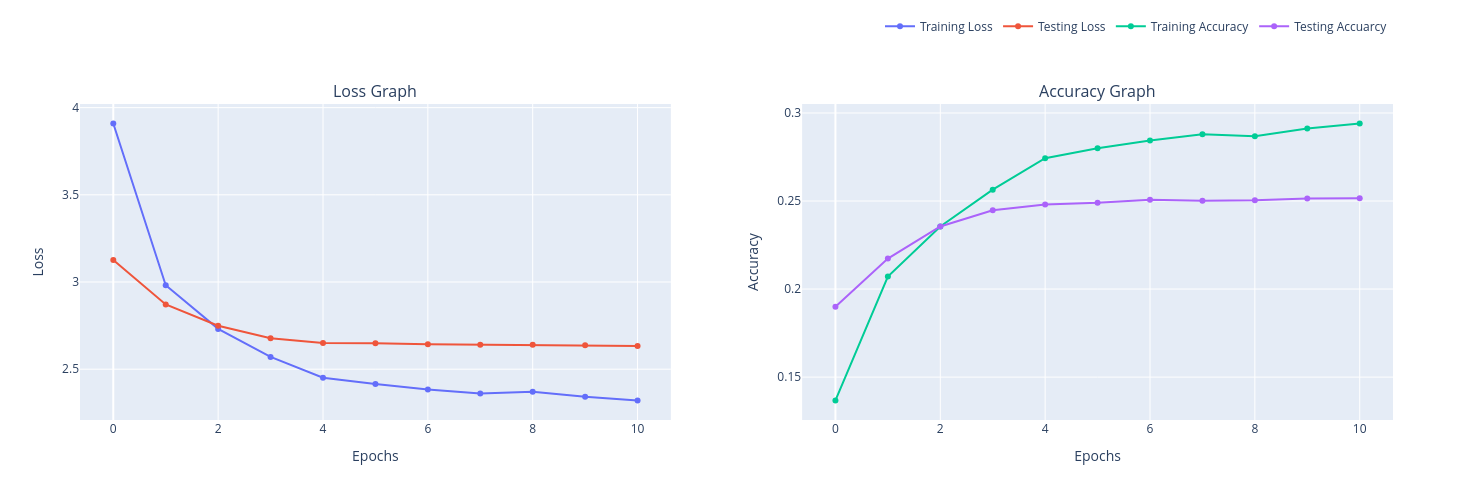

In [14]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("Loss Graph", "Accuracy Graph"))

fig.add_trace(go.Scatter(x=train_history['epoch'], y=train_history['loss'], mode='lines+markers', name='Training Loss'), row=1, col=1)
fig.add_trace(go.Scatter(x=val_history['epoch'], y=val_history['loss'], mode='lines+markers', name='Testing Loss'), row=1, col=1)

fig.add_trace(go.Scatter(x=train_history['epoch'], y=train_history['accuracy'], mode='lines+markers', name='Training Accuracy'), row=1, col=2)
fig.add_trace(go.Scatter(x=val_history['epoch'], y=val_history['accuracy'], mode='lines+markers', name='Testing Accuarcy'), row=1, col=2)

fig.update_layout(height=500, width=1200, xaxis_title='Epochs', yaxis_title='Loss', xaxis2_title='Epochs', yaxis2_title='Accuracy', legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.2,
        xanchor="right",
        x=1
    ))

fig.show()

- Perplexity Graph

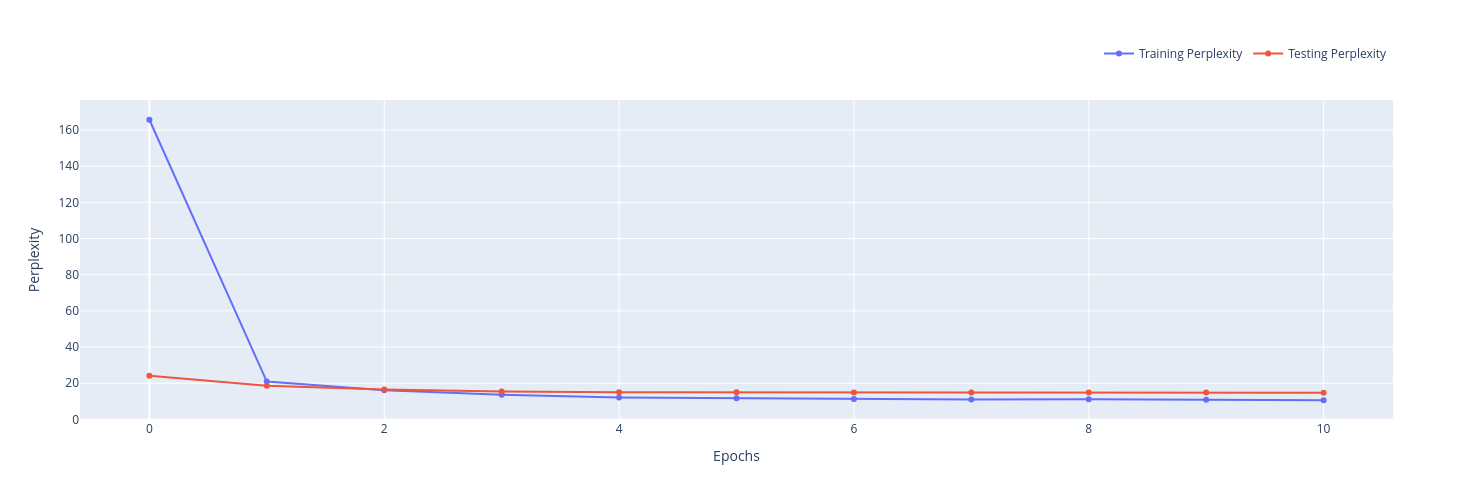

In [16]:
fig = make_subplots(rows=1, cols=1)

fig.add_trace(go.Scatter(x=train_history['epoch'], y=train_history['perplexity'], mode='lines+markers', name='Training Perplexity'), row=1, col=1)
fig.add_trace(go.Scatter(x=val_history['epoch'], y=val_history['perplexity'], mode='lines+markers', name='Testing Perplexity'), row=1, col=1)

fig.update_layout(height=500, width=700, xaxis_title='Epochs', yaxis_title='Perplexity', legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.1,
        xanchor="right",
        x=1
    ))

fig.show()

### Inference

In [19]:
def create_test_data(
    descriptor : DatasetDescriptor, 
    tokenizer : Tokenizer,
) -> tuple[CaptionsDataset, CaptionsDataset]:
    
    test_transfroms = Compose([
        RandomResizedCrop(size=(384,384)),
        ToTensor()
    ])

    test_data = CaptionsDataset(
        root=descriptor.images_dir,
        captions_df=descriptor.test_captions,
        caption_transform=tokenizer,
        img_transform=test_transfroms
    )

    return test_data

In [20]:
descriptor : DatasetDescriptor = DatasetDescriptor.get_by_name("flickr30k")
tokenizer : Tokenizer = Tokenizer.load(descriptor.vocab_path)
test_data = create_test_data(descriptor=descriptor, tokenizer=tokenizer)

In [32]:
len(test_data)

31785

In [ ]:
def inference(
    model : Transformer, 
    test_data : CaptionsDataset,
    device : str,
    batch_size : int = 8
) -> list[BatchResults]:

    model.eval()

    test_loader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4
    )

    results = []

    for batch in tqdm(test_loader):

        images, captions = batch
        images = images.to(device)
        captions = captions.to(device)

        with torch.no_grad():
            outputs = model(images, captions)
            #results.append(BatchResults(outputs, captions))

    return results

### Create caption generator

In [10]:
preporcessor = Compose([
    Resize((IMG_SIZE,IMG_SIZE)),
    ToTensor()
])

In [11]:
image_caption_generator = ImageCaptionGenerator(
    model, 
    tokenizer, 
    model_config["max_len"], 
    device=DEVICE,
    preprocessor=preporcessor
)

### Testing on images from the internet

In [12]:
dataset = ImageDirectory(root=TEST_IMAGES_DIR, return_name=True)

In [13]:
len(dataset)

20

In [14]:
def caption_image(img : Image.Image, name : str):
    
    caption = image_caption_generator.get_caption(img)

    dpi = matplotlib.rcParams['figure.dpi']

    figsize = img.size[0] / dpi, img.size[1] / dpi

    fig, ax = plt.subplots(figsize=figsize)

    ax.imshow(img)
    ax.set_title(caption)

    plt.axis('off')

    fig.savefig(os.path.join(TEST_RESULTS, name), bbox_inches='tight')

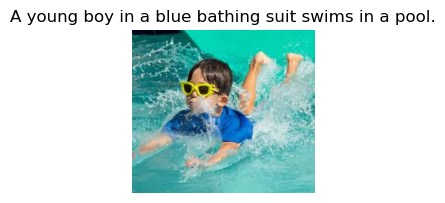

In [15]:
caption_image(*dataset[0])

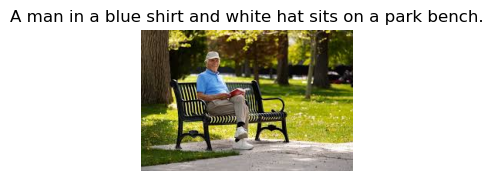

In [16]:
caption_image(*dataset[1])

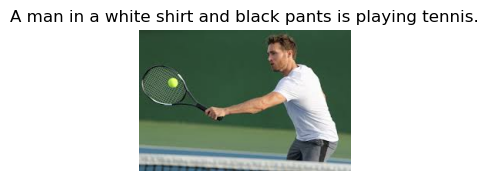

In [17]:
caption_image(*dataset[2])

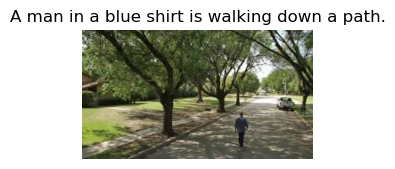

In [18]:
caption_image(*dataset[3])

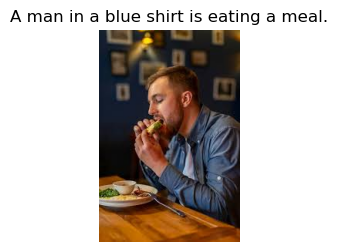

In [19]:
caption_image(*dataset[4])

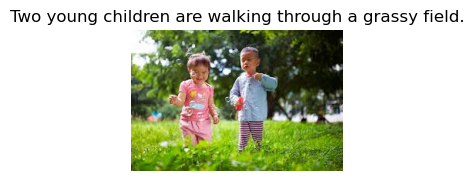

In [20]:
caption_image(*dataset[5])

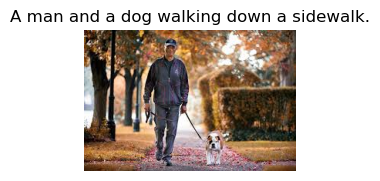

In [21]:
caption_image(*dataset[6])

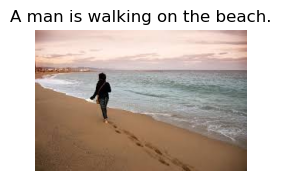

In [22]:
caption_image(*dataset[7])

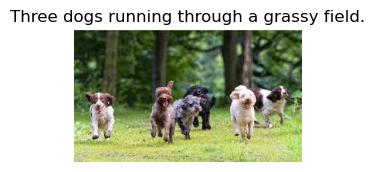

In [23]:
caption_image(*dataset[8])

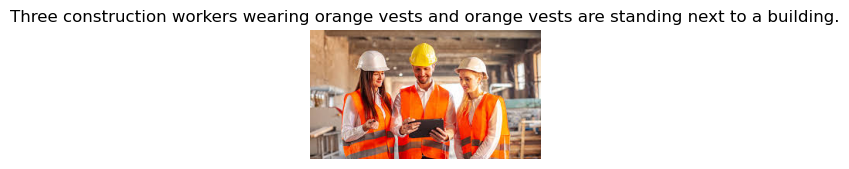

In [24]:
caption_image(*dataset[9])

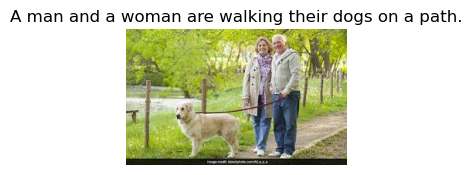

In [25]:
caption_image(*dataset[10])

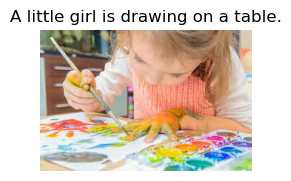

In [26]:
caption_image(*dataset[11])

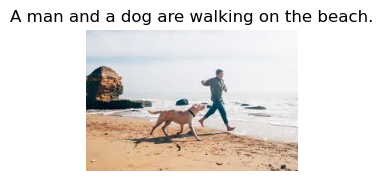

In [27]:
caption_image(*dataset[12])

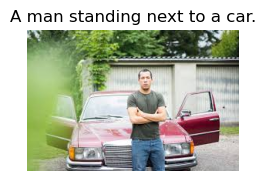

In [28]:
caption_image(*dataset[13])

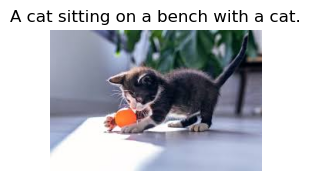

In [29]:
caption_image(*dataset[14])

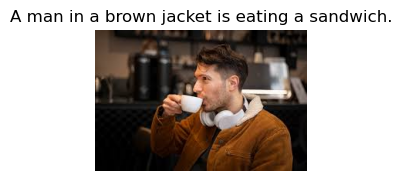

In [30]:
caption_image(*dataset[15])

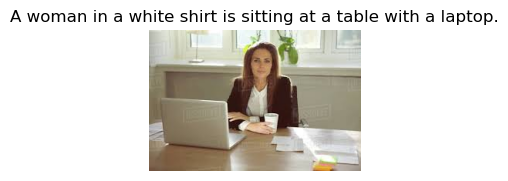

In [31]:
caption_image(*dataset[16])

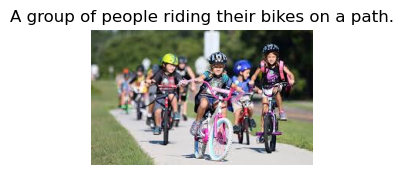

In [32]:
caption_image(*dataset[17])

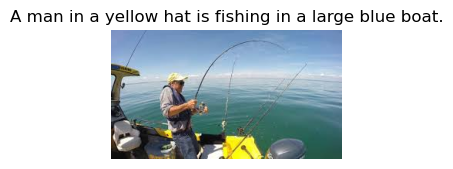

In [33]:
caption_image(*dataset[18])

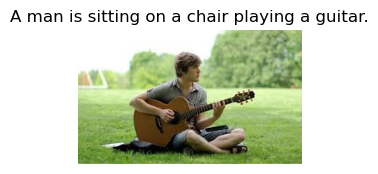

In [34]:
caption_image(*dataset[19])